In [ ]:
#Install DeepFace Library
!pip install deepface

In [ ]:
#Install Library
!pip install mediapipe

In [ ]:
import os
import cv2
import numpy as np
from deepface import DeepFace
from deepface.commons import functions

from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Definición de funciones

In [ ]:
def GetSVMPredictions(X_train, X_test, y_train, y_test):

    print("+++++++++++++++++++++++++++++++++++++++++++\n")
    print("SVM Normalization...")
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(X_train)
    test_X = scaler.transform(X_test)

    print("SVM training...")
    t0 = time()
    parameters = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
    # Grid serach across parameter range
    clf = GridSearchCV(
        SVC(kernel='rbf', class_weight='balanced'), parameters, cv=5
    )
    clf = clf.fit(train_X, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)


    print("Predicting")
    t0 = time()
    y_pred = clf.predict(test_X)
    print("done in %0.3fs" % (time() - t0))

    return y_pred, y_test

def GetKNNPredictions(k, X_train, X_test, y_train, y_test):

    t0 = time()
    # k = 5
    model_px = KNeighborsClassifier(n_neighbors = k)

    # fdtraining of model
    model_px.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))

    print("Predicting...")
    t0 = time()
    y_pred=model_px.predict(X_test)

    print("done in %0.3fs" % (time() - t0))


    return y_pred, y_test

In [ ]:
def calc_embs(X, batch_size=2):
    norm_images = prewhiten(X)
    pd = []
    for start in range(0, len(norm_images), batch_size):
        pd.append(model.predict_on_batch(norm_images[start:start+batch_size]))
    return l2_normalize(np.concatenate(pd))

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y


def LoadDataset(folder, ext):
    # Contador de número de clases del conjunto
    nclasses = 0
    # Contador de muestras por clase
    nperclass = []
    # Etiqueta de cada clase (nombre de la subcarpeta)
    classlabels = []
    # Inicializa estructuras de datos y sus correpondientes etiquetas
    X = []
    Y = []

    preprocessing = 1

    # Asume que en la ruta indicada hay una subcarpeta por clase
    for class_name in os.listdir(folder):
        # Cada subcarpeta implica una clase más
        nclasses += 1
        # Inicialmente esta clase no tiene muestras
        nsamples = 0

        # Compone la ruta
        class_folder = os.path.join(folder, class_name)
        for file_name in os.listdir(class_folder):
            # Asume imágenes en formato ext
            if file_name.endswith(ext):
                # Lee la imagen
                image = cv2.imread (os.path.join(class_folder, file_name))

                # Obtiene embeddings
                img1 = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

                # Get embeddings after preprocessing
                if preprocessing == 1:
                    img_embedding = calc_embs(np.array([img1]))
                else:
                    img_embedding = model.predict(img1[None,...])

                X.append(img_embedding[0])

                # Añade etiqueta numérica de la muestra
                Y.append(nclasses-1)

                #Incrementa el número de muestras
                nsamples += 1

        nperclass.append(nsamples)
        classlabels.append(class_name)

    #Convierte a numpy array X e Y
    X = np.array(X,dtype='float32')
    Y = np.array(Y,dtype='float64')

    # Muestra datos del conjunto leído
    # Depuración
    print("Features")
    print(X.shape)
    print(Y.shape)
    # Obtiene número de muestras y características
    n_samples , n_features = X.shape
    # Obtiene nombres de las clases
    class_names = np.array(classlabels)
    n_classes = class_names.shape[0]

    return X, Y, n_samples, n_features, n_classes, classlabels, nperclass, class_names



# Carga conjuntos de datos

Se proporciona la carpeta, a través de la variable folder, donde cada subcarpeta se corresponde con una clase.
Cada clase contiene muestras en forma de imágenes jpg, todas del mismo tamaño. Obtiene embeddings Facenet

In [ ]:
# Modelos disponibles ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib']
model = DeepFace.build_model("Facenet")
target_size = model.layers[0].input_shape
dim = (int(target_size[0][1]), int(target_size[0][2]))

folder = "C:/Users/Asus/Documents/Estudio/VC/P6VC/DatabaseGender59x65"

print('Loading dataset')
X, Y, nsamples, class_name, nperclass, classlabels, width, height = LoadDataset(folder,'.jpg')

#Convierte a numpy array X e Y
X = np.array(X,dtype='float32')
Y = np.array(Y,dtype='float64')

# Obtiene número de muestras y características
n_samples , n_features = X.shape
# Obtiene nombres de las clases
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

print("Dataset info:")
print("# samples: %d" % n_samples)
print("# features: %d" % n_features)
print("# classes: %d" % n_classes)
print("classes %s" % classlabels)
print("samples per class %s" % str(nperclass)[1:-1] )




Loading dataset
Features
(1184, 128)
(1184,)
Dataset info:
# samples: 1184
# features: 128
# classes: 2
classes ['Female', 'Male']
samples per class 


# Diseña conjunto experimental k-fold

Divide los datos k veces en conjunto de entrenamiento y test

In [ ]:
# StratifiedKFold
# Define el número de subconjuntos a considerar
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=4, shuffle=True)
#Distribución de muestras por fold
fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    fold += 1

Fold 1
# samples in training set 947
# samples in test set 237
Fold 2
# samples in training set 947
# samples in test set 237
Fold 3
# samples in training set 947
# samples in test set 237
Fold 4
# samples in training set 947
# samples in test set 237
Fold 5
# samples in training set 948
# samples in test set 236


# Lanza experimento

In [ ]:
# Embeddings
precs_facenet_svm, recs_facenet_svm = [], []
precs_facenet_knn, recs_facenet_knn = [], []


# Recorre folds
fold = 1
while fold <= kfold:
    accs, precs, recs = [], [], []
    for train_index, test_index in skf.split(X, Y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        print("***\nFold %d" % fold)
        #División de muestras de entreno y test
        X_train, X_test = X[train_index], X[test_index]
        #Etiquetas de las muestras
        y_train, y_test = Y[train_index], Y[test_index]


        #Facenet+KNN
        y_pred, y_test = GetKNNPredictions(11, X_train, X_test,y_train, y_test)
        print("\nFacenet+KNN Metrics")
        precs_facenet_knn.append(precision_score(y_test, y_pred, average='weighted'))
        recs_facenet_knn.append(recall_score(y_test, y_pred, average='weighted'))
        print(classification_report(y_test, y_pred, target_names=class_names))
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

        #Facenet+SVM
        y_pred, y_test = GetSVMPredictions(X_train, X_test,y_train, y_test)
        print("\nFacenet+SVM Metrics")
        precs_facenet_svm.append(precision_score(y_test, y_pred, average='weighted'))
        recs_facenet_svm.append(recall_score(y_test, y_pred, average='weighted'))
        print(classification_report(y_test, y_pred, target_names=class_names))
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


    fold += 1

print("Facenet+KNN Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_facenet_knn) , np.mean(recs_facenet_knn) ))
print("Facenet+SVM Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_facenet_svm) , np.mean(recs_facenet_svm) ))


***
Fold 1
done in 0.003s
Predicting...
done in 0.708s

Facenet+KNN Metrics
              precision    recall  f1-score   support

      Female       0.97      0.94      0.96       117
        Male       0.94      0.97      0.96       120

    accuracy                           0.96       237
   macro avg       0.96      0.96      0.96       237
weighted avg       0.96      0.96      0.96       237

[[110   7]
 [  3 117]]
+++++++++++++++++++++++++++++++++++++++++++

SVM Normalization...
SVM training...
done in 20.271s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1)
Predicting
done in 0.033s

Facenet+SVM Metrics
              precision    recall  f1-score   support

      Female       0.96      0.91      0.93       117
        Male       0.92      0.96      0.94       120

    accuracy                           0.94       237
   macro avg       0.94      0.94      0.94       237
weighted avg       0.94      0.94      0.94       237

[[107  10]
 [  

#DETECCIÓN DE CARAS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [200]:
from typing import Tuple, Union
import math

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 2
FONT_THICKNESS = 2
TEXT_COLOR = (255, 255, 255)


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px
def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  man = 0
  woman = 0

  for detection in detection_result.detections:
    bbox = detection.bounding_box

    face = annotated_image[bbox.origin_y:bbox.origin_y+bbox.height, bbox.origin_x:bbox.origin_x+bbox.width]
    obj = DeepFace.analyze(face, enforce_detection=False, actions =['gender'])
    cv2_imshow(face)

    # Dibujar el genero
    result_text = obj[0].get('dominant_gender')

    if result_text == "Man":
      man += 1
    elif result_text == "Woman":
      woman += 1

    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  # Calcular los porcentajes
  if woman == 0:
    man_percent = (man / len(detection_result.detections))* 100
    woman_percent = 100 - man_percent
  else:
    woman_percent = (woman /len(detection_result.detections))* 100
    man_percent = 100 - woman_percent
  print("Porcentaje mujer:", woman_percent, "Porcentaje hombre:", man_percent)
  if woman_percent == man_percent:
      return annotated_image

  # Separamos canales
  blue_channel, green_channel, red_channel = cv2.split(annotated_image)

  # Aplicar el filtro segun el porcentaje de mujeres y hombres
  if woman_percent > man_percent:
    blue_channel = blue_channel + woman_percent*255
    red_channel = red_channel + woman_percent*255
  elif man_percent > woman_percent:
    green_channel = green_channel+man_percent*255

  # Comprobar que están dentro de rango
  red_channel = np.clip(red_channel, 0, 255).astype(np.uint8)
  blue_channel = np.clip(blue_channel, 0, 255).astype(np.uint8)
  green_channel = np.clip(green_channel, 0, 255).astype(np.uint8)

  # Unir los canales
  annotated_image = cv2.merge([blue_channel, green_channel, red_channel])
  return annotated_image


In [ ]:
from google.colab.patches import cv2_imshow

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


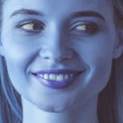

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


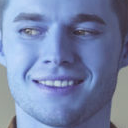

Porcentaje mujer: 50.0 Porcentaje hombre: 50.0


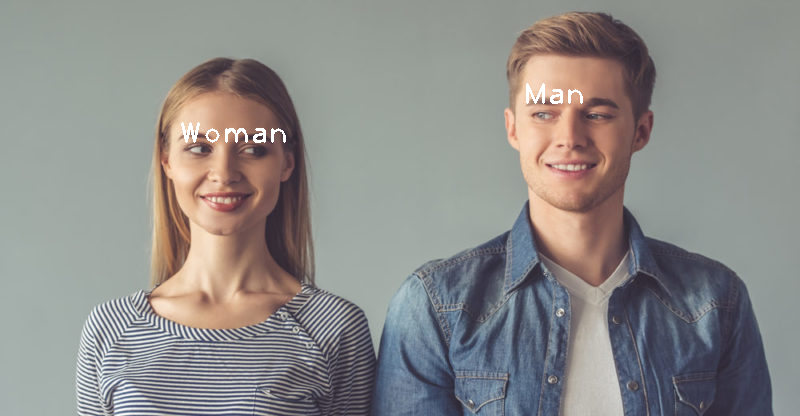

In [198]:
# Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path='/content/drive/My Drive/P6/blaze_face_short_range.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file('/content/drive/My Drive/P6/dos2.jpg')

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)


Action: gender: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


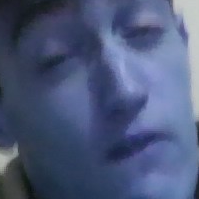

Porcentaje mujer: 0.0 Porcentaje hombre: 100.0


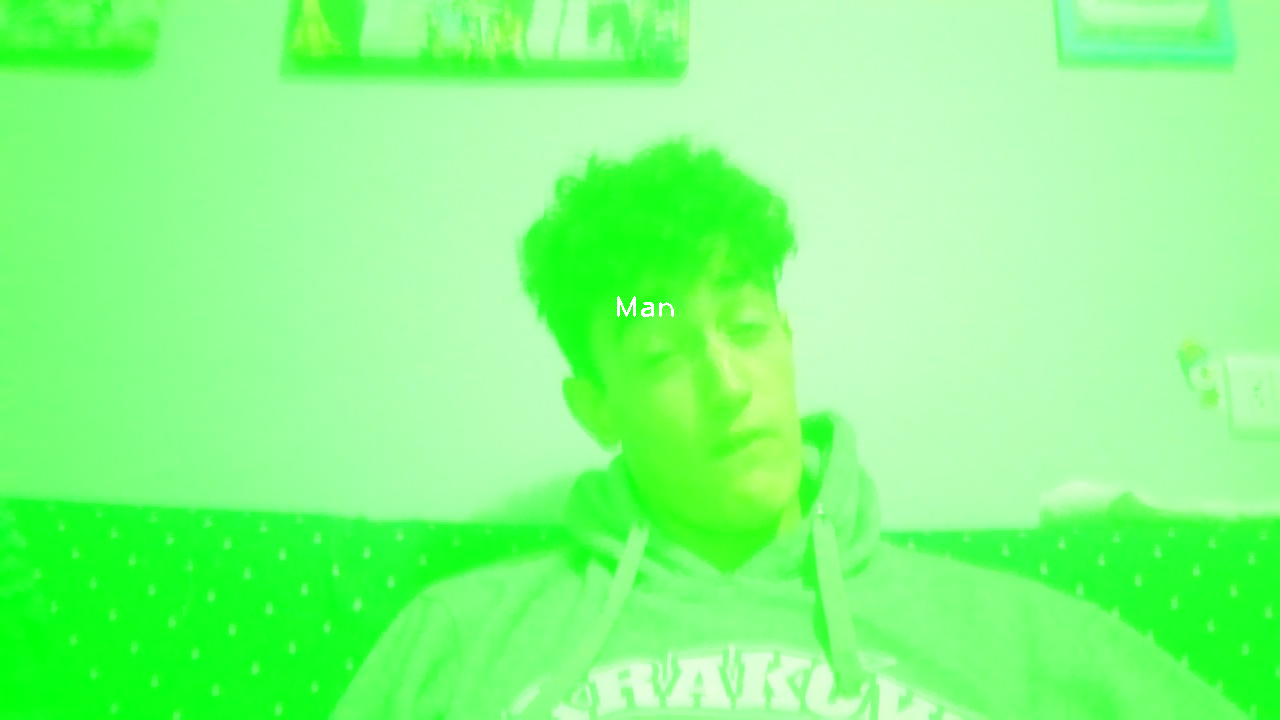

In [201]:
# STEP 3: Load the input image.
image = mp.Image.create_from_file('/content/drive/My Drive/P6/saul.jpg')

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


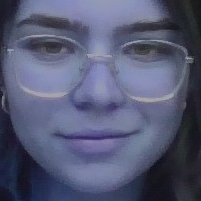

Porcentaje mujer: 100.0 Porcentaje hombre: 0.0


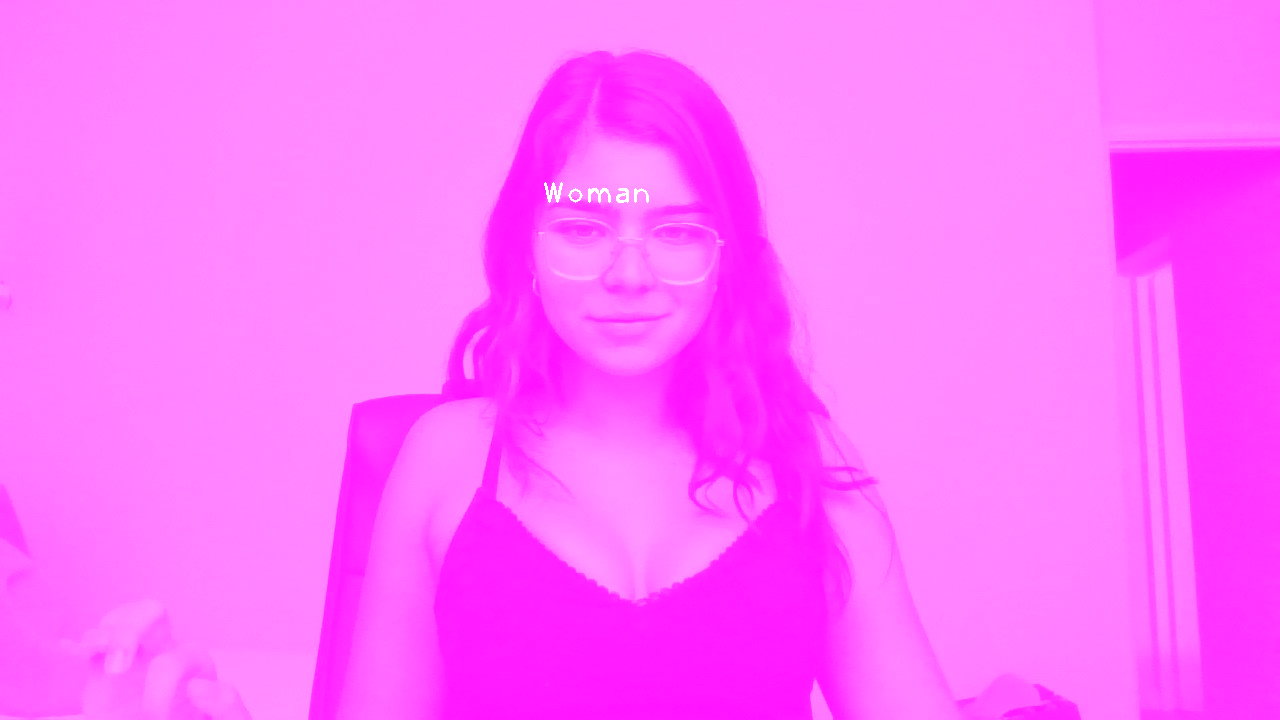

In [192]:
# STEP 3: Load the input image.
image = mp.Image.create_from_file('/content/drive/My Drive/P6/sara.jpg')

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


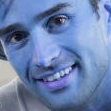

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


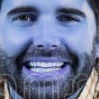

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


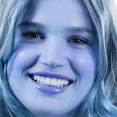

Porcentaje mujer: 33.33333333333333 Porcentaje hombre: 66.66666666666667


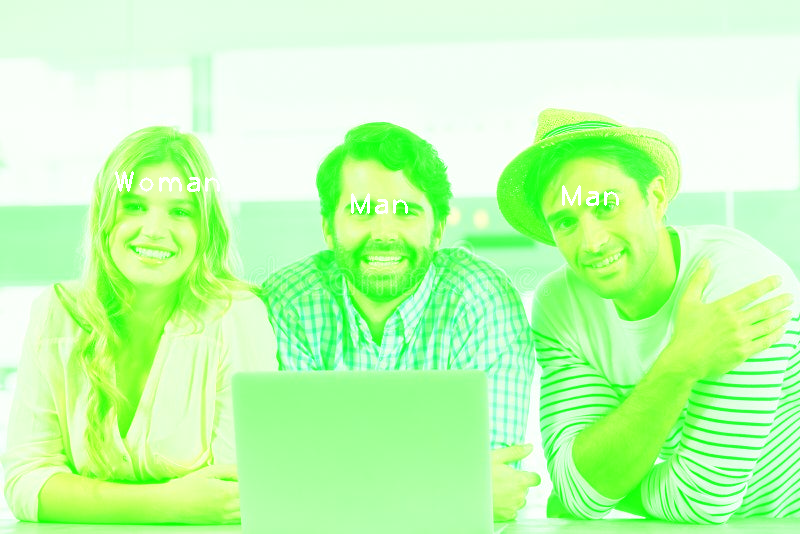

In [193]:
# STEP 3: Load the input image.
image = mp.Image.create_from_file('/content/drive/My Drive/P6/2h1m.jpg')

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)

Action: gender: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


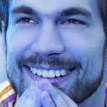

Action: gender: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


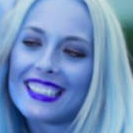

Action: gender: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


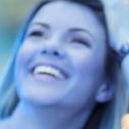

Porcentaje mujer: 66.66666666666666 Porcentaje hombre: 33.33333333333334


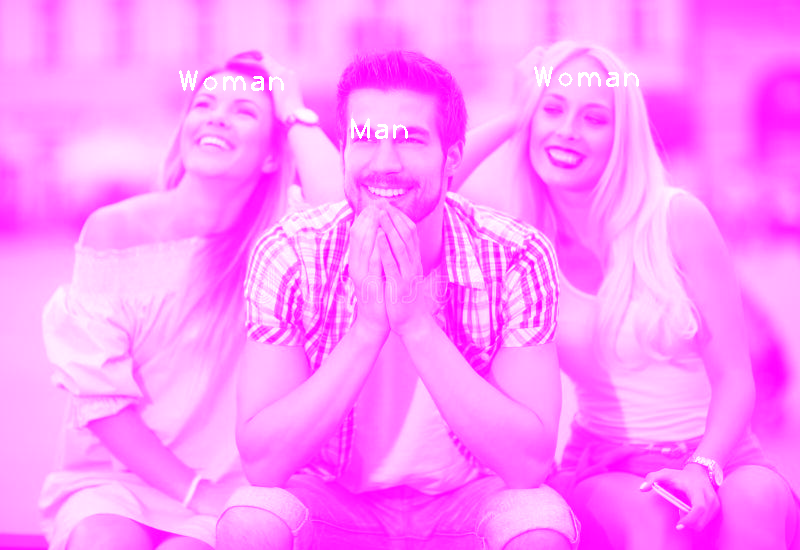

In [203]:
# STEP 3: Load the input image.
image = mp.Image.create_from_file('/content/drive/My Drive/P6/2m1h.jpg')

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)